# Определение стоимости автомобилей

В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
# игнорирование предупреждений о несоответствии версий
import warnings
warnings.filterwarnings('ignore')

# работа с таблицами
import pandas as pd
import numpy as np

# визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# работа с моделями
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

# инструменты
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
from lightgbm import LGBMModel
from sklearn.impute import SimpleImputer

# Проверим признаки на корреляцию
! pip install phik
import phik
from phik import resources, report

     |████████████████████████████████| 679 kB 1.3 MB/s eta 0:00:01


In [2]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', None)
 
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)

import time

### Изучение данных

In [4]:
data = pd.read_csv('/datasets/autos.csv')

In [5]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Для начала сотит определить какая информация нам требуется для определения стоимости, а какой можно пренебречь.

Следующие признаки не целесообразны при оценке:

- DateCrawled — дата скачивания анкеты из базы
- RegistrationMonth — месяц регистрации автомобиля
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

### Обработка таблицы

Для удобства приведем названия столбцов к змеиному регистру

In [7]:
def snake_columns(data):
    name_list = []
    for i in data:
        name = []
        for j in range(len(i)):
            if i[j].isupper():
                name.append('_')
                name.append(i[j].lower())
            else:
                name.append(i[j])
        del name[0]  
        name_list.append(''.join(name))
    return name_list

In [8]:
data.columns = snake_columns(data)

Сохраним год размещения для вычисления возраста автомобиля.

In [9]:
data['date_created'] = pd.to_datetime(
    data['date_created'], format='%Y-%m-%dT%H:%M:%S'
)

In [10]:
data['date_created'] = pd.DatetimeIndex(data['date_created']).year

In [11]:
data.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016,0,60437,2016-04-06 10:17:21


Удалим ненужные столбцы

In [12]:
data = data.drop(['date_crawled', 'registration_month', 'postal_code', 'last_seen', 'number_of_pictures'],
                 axis=1)

In [13]:
data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,date_created
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,2016
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,2016
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,2016
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,2016
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,2016


### Добавление дополнительных признаков

In [14]:
data[(data['registration_year'] > 2023) | (data['registration_year'] < 1960)].count()

price                527
vehicle_type         282
registration_year    527
gearbox              257
power                527
model                290
kilometer            527
fuel_type            287
brand                527
repaired             202
date_created         527
dtype: int64

В столбще действительно присутствует небольшое количество аномалий, учитывая их количество, можно безболезненно удалить объекты.

In [15]:
data = data.drop(index=data[(data['registration_year'] > data['date_created']) | (data['registration_year'] < 1960)].index)

Добавим дополнительный признак - годы эксплуатации

In [16]:
data['age'] = data['date_created'] - data['registration_year']

В открытых источниках указывают предел работы для среднестатистического двигателя в размере 350 000 км пробега, введем процент износа на основании этой константы.

In [17]:
data['damage_percent'] = round((data['kilometer'] / 350000 * 100), 0).astype('int')

Введем признак, обозначающий сумму на оставшийся километраж (350 000)

In [18]:
data['eur_durable'] = round(data['price'] / (300000 - data['kilometer']) * 100).astype('int')

In [19]:
data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,date_created,age,damage_percent,eur_durable
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,2016,23,43,0
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,2016,5,36,10
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,2016,12,36,6
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,2016,15,43,1
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,2016,8,26,2


### Обработка нулевых значений

<AxesSubplot:>

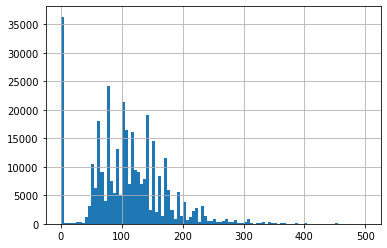

In [20]:
data['power'].hist(bins=100, range=(0,500))

В столбце power у нас имеются нулевые значения, что для автомобиля с двигателем недопустимо.

In [21]:
data.loc[data['power'] <= 10, 'power'] = np.NaN

In [22]:
data['power'].isna().sum()

36482

Исследование данных показало, что мощность двигателя среди одинаковых автомобилей может сильно отличаться. Причем не всегда мощность двигателя имеет взаимосвязь с ценой. Поэтому, чтобы не терять данные, в дальнейше для заполнения этого столбца используем KNNImputer.

In [23]:
data.loc[data['price'] == 0]['price'].count()

9939

Имеется доля данных с целевым признаком равным 0, это введет в заблуждение модель, прeдлагаю дропнуть его. Помимо этого, предлагается удалить предложения ниже 500 евро, предложения со стоимостью ниже не обоснованы в цене, либо не на ходу.

In [24]:
data.loc[data['price'] <= 500, 'price'] = np.NaN

In [25]:
data = data.dropna(subset=['price'])

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299550 entries, 1 to 354368
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              299550 non-null  float64
 1   vehicle_type       286178 non-null  object 
 2   registration_year  299550 non-null  int64  
 3   gearbox            288238 non-null  object 
 4   power              274956 non-null  float64
 5   model              287135 non-null  object 
 6   kilometer          299550 non-null  int64  
 7   fuel_type          281937 non-null  object 
 8   brand              299550 non-null  object 
 9   repaired           252147 non-null  object 
 10  date_created       299550 non-null  int64  
 11  age                299550 non-null  int64  
 12  damage_percent     299550 non-null  int64  
 13  eur_durable        299550 non-null  int64  
dtypes: float64(2), int64(6), object(6)
memory usage: 34.3+ MB


In [27]:
#data.loc[(data['brand'] == 'volkswagen') & (data['model'] == 'golf') & (data['fuel_type'] == 'petrol')
#        & (data['registration_year'] == 1993)& (data['vehicle_type'] == 'sedan') & (data['repaired'] == 'no')].head(30)

### Работа с пропусками

In [28]:
# data.pivot_table(values='price', index=['brand', 'model', 'vehicle_type', 'fuel_type'], aggfunc=['count'])

Для устранения пропусков, предлагается добавить класс unspecified так, как по сочетанию отдельных признаков не представляется возможным достоверно определить их значение.

In [29]:
data['repaired'] = data['repaired'].fillna('unspecified')
data['gearbox'] = data['gearbox'].fillna('unspecified')
data['fuel_type'] = data['fuel_type'].fillna('unspecified')
data['vehicle_type'] = data['vehicle_type'].fillna('unspecified')
data['model'] = data['model'].fillna('unspecified')

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299550 entries, 1 to 354368
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              299550 non-null  float64
 1   vehicle_type       299550 non-null  object 
 2   registration_year  299550 non-null  int64  
 3   gearbox            299550 non-null  object 
 4   power              274956 non-null  float64
 5   model              299550 non-null  object 
 6   kilometer          299550 non-null  int64  
 7   fuel_type          299550 non-null  object 
 8   brand              299550 non-null  object 
 9   repaired           299550 non-null  object 
 10  date_created       299550 non-null  int64  
 11  age                299550 non-null  int64  
 12  damage_percent     299550 non-null  int64  
 13  eur_durable        299550 non-null  int64  
dtypes: float64(2), int64(6), object(6)
memory usage: 34.3+ MB


Оставшиеся пропуски попробуем заполнить импутером.

### Работа с аномалиями

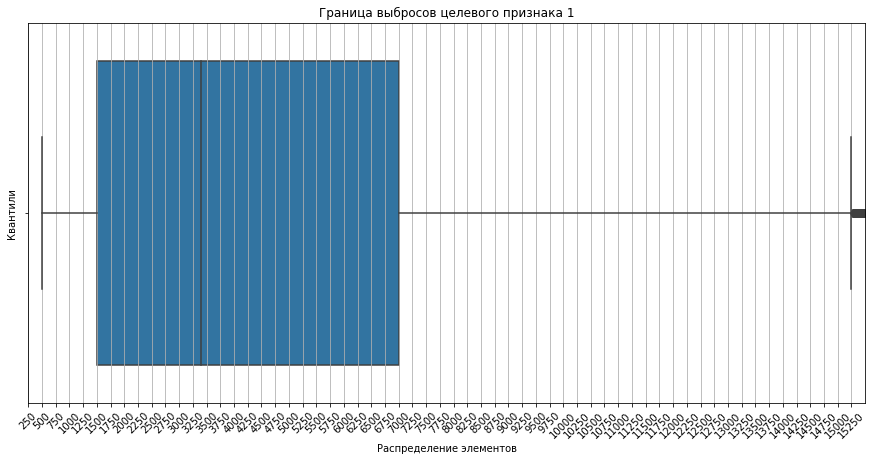

In [31]:
plt.figure(figsize=(15, 7))
plt.xticks(range(0, 15500, 250), rotation=45)
plt.xlim(250,15500)
plt.grid(True)
ax = sns.boxplot(x=data['price'])
plt.title('Граница выбросов целевого признака 1')
ax.set_xlabel('Распределение элементов')
ax.set_ylabel('Квантили')

plt.show()

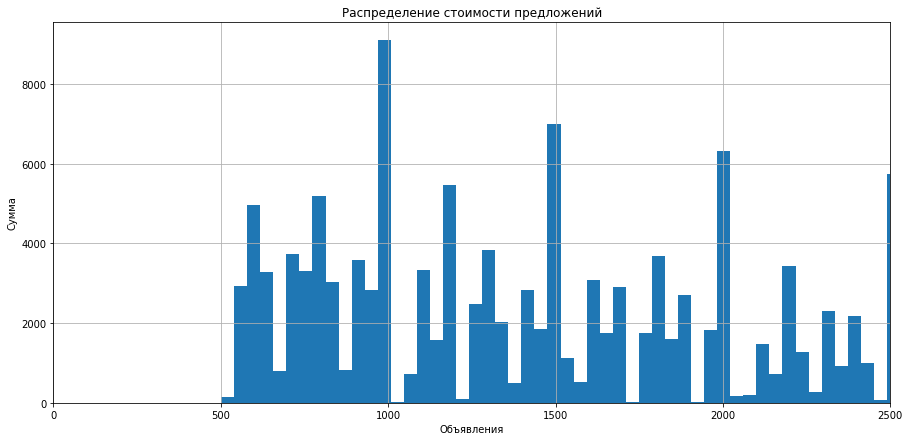

In [32]:
plt.figure(figsize=(15, 7))
#plt.xticks(range(0, 15500, 500), rotation=45)
plt.xlim(0,2500)
plt.grid(True)
ax = data['price'].hist(bins=500)
plt.title('Распределение стоимости предложений')
ax.set_xlabel('Объявления')
ax.set_ylabel('Сумма')

plt.show()

Обозначим границу выбросов в районе 15 000 евро. Для корректного обучения модели.

In [33]:
data.loc[data['price'] <= 10]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,date_created,age,damage_percent,eur_durable


In [34]:
data = data.loc[data['price'] <= 15000]

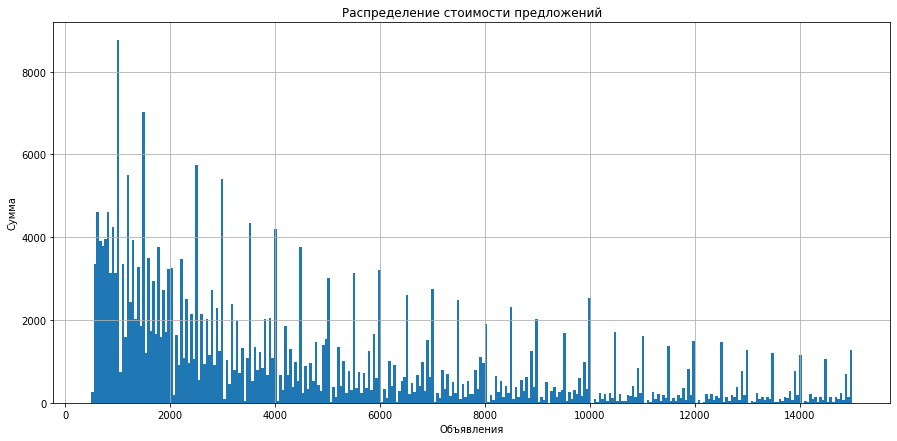

In [35]:
plt.figure(figsize=(15, 7))

plt.grid(True)
ax = data['price'].hist(bins=300)
plt.title('Распределение стоимости предложений')
ax.set_xlabel('Объявления')
ax.set_ylabel('Сумма')

plt.show()

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284941 entries, 2 to 354368
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              284941 non-null  float64
 1   vehicle_type       284941 non-null  object 
 2   registration_year  284941 non-null  int64  
 3   gearbox            284941 non-null  object 
 4   power              260735 non-null  float64
 5   model              284941 non-null  object 
 6   kilometer          284941 non-null  int64  
 7   fuel_type          284941 non-null  object 
 8   brand              284941 non-null  object 
 9   repaired           284941 non-null  object 
 10  date_created       284941 non-null  int64  
 11  age                284941 non-null  int64  
 12  damage_percent     284941 non-null  int64  
 13  eur_durable        284941 non-null  int64  
dtypes: float64(2), int64(6), object(6)
memory usage: 32.6+ MB


По итогам блока данных стало меньше, но они больше подходят для обучения модели ввиду меньшего содержания выбросов и отсутствия незаполненных значений.

In [37]:
#data = data.drop(['vehicle_type', 'date_created'], axis=1)

In [38]:
data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,date_created,age,damage_percent,eur_durable
2,9800.0,suv,2004,auto,163.0,grand,125000,gasoline,jeep,unspecified,2016,12,36,6
3,1500.0,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no,2016,15,43,1
4,3600.0,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no,2016,8,26,2
5,650.0,sedan,1995,manual,102.0,3er,150000,petrol,bmw,yes,2016,21,43,0
6,2200.0,convertible,2004,manual,109.0,2_reihe,150000,petrol,peugeot,no,2016,12,43,1


<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 
        
        
Так как ты создавал новые фичи очень рекомендую провести корреляционный анализ.

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b>
    
Провел, увидел, что допустил утечку данных в одной из новых фич.
</div>

In [39]:
# Выделим признаки для расчета
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

newdf = data.select_dtypes(include=numerics).columns

In [40]:
# Выделим признаки для расчета
interval_cols = newdf
phik_overview = data.phik_matrix(interval_cols=interval_cols)

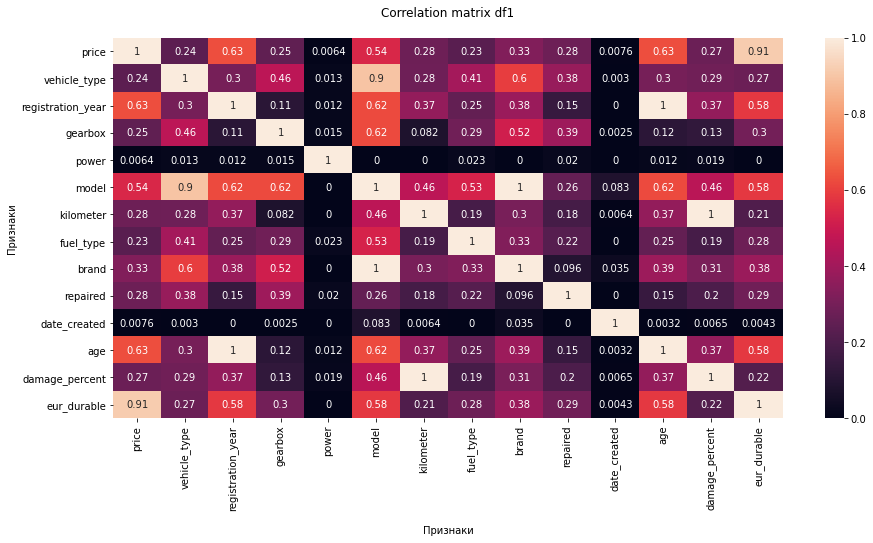

In [41]:
# Строим матрицу корреляции
plt.figure(figsize=(15, 7))

plot_correlation_matrix = sns.heatmap(phik_overview, annot = True)
plot_correlation_matrix.set(xlabel='\nПризнаки', ylabel='Признаки',
                            title = "Correlation matrix df1\n")
plt.yticks(rotation=0)
plt.show()

Признак eur_durable обладает высокой корреляцией, что говорит об утечке данных из целевого признака. Дропаем

In [42]:
data = data.drop(columns=['eur_durable'])

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284941 entries, 2 to 354368
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              284941 non-null  float64
 1   vehicle_type       284941 non-null  object 
 2   registration_year  284941 non-null  int64  
 3   gearbox            284941 non-null  object 
 4   power              260735 non-null  float64
 5   model              284941 non-null  object 
 6   kilometer          284941 non-null  int64  
 7   fuel_type          284941 non-null  object 
 8   brand              284941 non-null  object 
 9   repaired           284941 non-null  object 
 10  date_created       284941 non-null  int64  
 11  age                284941 non-null  int64  
 12  damage_percent     284941 non-null  int64  
dtypes: float64(2), int64(5), object(6)
memory usage: 30.4+ MB


## Обучение моделей

Напишем функцию оценки rmse

In [44]:
def rmse (target, predict):
    return mean_squared_error(target, predict)**0.5

In [45]:
rmse_scorer = make_scorer(rmse, greater_is_better=False)

Разделим выборки

In [46]:
features = data.drop(['price'], axis=1)
target = data['price']

X_train_no_scaled, X_test_no_scaled, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=12345)

In [47]:
X_train, X_test = X_train_no_scaled, X_test_no_scaled

В таблице большое количество категориальных признаков, применим для этого порядковое кодирование.

In [48]:
numeric = ['registration_year', 'power', 'kilometer','date_created','age','damage_percent']
scaler = StandardScaler()
X_train[numeric] = scaler.fit_transform(X_train_no_scaled[numeric])
X_test[numeric] = scaler.transform(X_test_no_scaled[numeric])

In [49]:
numeric_2 = ['vehicle_type', 'gearbox','model','fuel_type','brand','repaired']
ode = OrdinalEncoder(handle_unknown='use_encoded_value', dtype='int', unknown_value=-1)
X_train[numeric_2] = ode.fit_transform(X_train[numeric_2])
X_test[numeric_2] = ode.transform(X_test[numeric_2])

In [50]:
X_test.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,date_created,age,damage_percent
70690,4,0.823778,1,0.121496,242,0.573252,6,2,0,0.009224,-0.823761,0.570123
216143,7,0.354251,0,0.121496,11,0.573252,2,2,1,0.009224,-0.354235,0.570123
117328,4,0.041233,1,0.259604,170,0.573252,2,38,0,0.009224,-0.041218,0.570123
91745,4,-0.271786,0,0.507245,15,0.573252,6,2,1,0.009224,0.271799,0.570123
104036,0,0.510760,1,0.250079,236,0.573252,2,36,0,0.009224,-0.510744,0.570123


In [51]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
ct = make_column_transformer(
     (imp_mean, ['power']),
      remainder='passthrough')

X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

In [52]:
pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.054710,5.0,-0.584804,1.0,116.0,0.573252,6.0,38.0,0.0,0.009224,0.584817,0.570123
1,-0.307113,5.0,0.823778,1.0,173.0,-0.822190,6.0,38.0,0.0,0.009224,-0.823761,-0.791494
2,-0.054710,0.0,-0.584804,1.0,112.0,0.573252,6.0,10.0,0.0,0.009224,0.584817,0.570123
3,-0.235678,4.0,-0.271786,1.0,116.0,-0.124469,6.0,38.0,0.0,0.009224,0.271799,-0.110686
4,0.021487,8.0,0.980287,1.0,44.0,-0.124469,6.0,36.0,1.0,0.009224,-0.980270,-0.110686


### Константная модель

In [53]:
time_1 = time.time()
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
time_2 = time.time()
time_edu = time_2 - time_1
print('Время обучения модели:', time_edu, 'сек.')

Время обучения модели: 0.0009143352508544922 сек.


In [54]:
time_1 = time.time()
dummy_pred = dummy_regr.predict(X_train)
time_2 = time.time()
time_pred = time_1 - time_1
print('Время обучения модели:', time_pred, 'сек.')
mean_squared_error(dummy_pred, y_train)**0.5

Время обучения модели: 0.0 сек.


3646.0543535347747

In [55]:
rmse(y_train, dummy_pred)

3646.0543535347747

In [56]:
result_table = pd.DataFrame([time_edu, time_pred, rmse(y_train, dummy_pred)], columns=['Constant'],
                           index=['Education', 'Prediction', 'RMSE'])
result_table

,Constant
Education,0.000914
Prediction,0.000000
RMSE,3646.054354


Константная модель ошибается на 3629 евро, что является первым порогом при прохождении теста на качество модели не считая условия задачи в 2500 RMSE.

### GradientBoostingRegressor

In [57]:
gbr = GradientBoostingRegressor(random_state=12345)

In [58]:
gbr.get_params().keys()

dict_keys(['alpha', 'ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [59]:
gbr_params = {}
gbr_params['n_estimators'] = [i for i in np.arange(300, 400, 10)]
gbr_params['max_depth'] = [i for i in np.arange(4, 8)]
gbr_params['min_samples_split'] = [i for i in np.arange(6, 12, 2)]
gbr_params['max_features'] = ['auto', 'sqrt', 'log2']

In [60]:
gbr_random = RandomizedSearchCV(gbr, gbr_params, n_iter=10, cv=3, verbose=2,
                                  random_state=12345, scoring=rmse_scorer, n_jobs=-1)

In [61]:
%%time
gbr_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END max_depth=4, max_features=sqrt, min_samples_split=6, n_estimators=380; total time=  21.0s
[CV] END max_depth=4, max_features=sqrt, min_samples_split=6, n_estimators=380; total time=  21.7s
[CV] END max_depth=4, max_features=sqrt, min_samples_split=6, n_estimators=380; total time=  23.5s
[CV] END max_depth=6, max_features=log2, min_samples_split=6, n_estimators=330; total time=  30.3s


KeyboardInterrupt: 

In [62]:
gbr_random.best_params_

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'

Лучшие параметры модели следующие {'n_estimators': 340, 'min_samples_split': 10, 'max_depth': 6}

In [ ]:
abs(gbr_random.best_score_)

На основе найденных параметров подсчитаем время обучения и предсказания модели и качество.

In [ ]:
# Модель для быстрого запуска проекта с уже найденными параметрами
time_1 = time.time()
gbr = GradientBoostingRegressor(n_estimators=300, min_samples_split=6, max_depth=7, max_features='sqrt', random_state=12345)
gbr.fit(X_train, y_train)
time_2 = time.time()
time_edu = time_2 - time_1
print('Время обучения модели:', time_edu, 'сек.')

In [ ]:
time_1 = time.time()
gbr_pred = gbr.predict(X_train)
time_2 = time.time()
time_pred = time_2 - time_1
print('Время предсказания модели:', time_pred, 'сек.')

Проверим качество модели на тестовой выборке с помощью кросс валидации

Сформируем таблицу, в которую будем сохранять результаты исследований

In [ ]:
result_table['GradientBoosting'] = [time_edu, time_pred, abs(gbr_random.best_score_)]
result_table

Визуализируем предсказания модели

In [ ]:
plt.figure(figsize=(12,7))
plt.grid(True)
plt.title('Визуализация предсказаний модели')
plt.xlabel('Признак (Процент износа)')
plt.ylabel('Целевой признак')

sns.scatterplot(x=X_train_no_scaled['damage_percent'], y=y_train, color="black",
                alpha=0.05)
sns.scatterplot(x=X_train_no_scaled['damage_percent'], y=gbr_pred, color="red",
                alpha=0.1)

plt.show()


По итогу, Градиентный бустинг показал отклонение в размере 433.51 RMSE, что преодоленвает порог в 2500.

2.0 По итогу, Градиентный бустинг показал отклонение в размере 1440 RMSE, что преодоленвает порог в 2500. 

### Случайный лес

In [ ]:
forest = RandomForestRegressor(random_state=12345)

In [ ]:
forest.get_params().keys()

In [ ]:
distributions = {}
distributions['n_estimators'] = [i for i in np.arange(150, 500, 15)]
distributions['max_depth'] = [None] + [i for i in range(1, 10)]
distributions['min_samples_split'] = [i for i in np.arange(4, 14, 2)]
distributions['bootstrap'] = [True, False]

In [ ]:
forest_random = RandomizedSearchCV(forest, distributions, n_iter=10, cv=3, verbose=2,
                                  random_state=12345, scoring=rmse_scorer, n_jobs=-1)

In [ ]:
%%time
forest_random.fit(X_train, y_train)

In [ ]:
forest_random.best_params_

In [ ]:
abs(forest_random.best_score_)

In [ ]:
# Модель для быстрого запуска проекта с уже найденными параметрами
time_1 = time.time()
forest = RandomForestRegressor(n_estimators=405, min_samples_split=4, max_depth=8, bootstrap=False, random_state=12345)
forest.fit(X_train, y_train)
time_2 = time.time()
time_edu = time_2 - time_
print('Время обучения модели:', time_edu, 'сек.')

In [ ]:
time_1 = time.time()
forest_pred = forest.predict(X_train)
time_2 = time.time()
time_pred = time_2 - time_1
print('Время предсказания модели:', time_pred, 'сек.')

In [ ]:
result_table['RandomForest'] = [time_edu, time_pred, abs(forest_random.best_score_)]
result_table

In [ ]:
plt.figure(figsize=(12,7))
plt.grid(True)
plt.title('Визуализация предсказаний модели')
plt.xlabel('Признак (Процент износа)')
plt.ylabel('Целевой признак')

sns.scatterplot(x=X_train_no_scaled['damage_percent'], y=y_train, color="black",
                alpha=0.05)
sns.scatterplot(x=X_train_no_scaled['damage_percent'], y=forest_pred, color="red",
                alpha=0.1)

plt.show()

Судя по диаграмме, модель Случайного леса менее вариативна при предсказании, разброс цены по отдельным классам гораздо уже, чем у градиентного бустинга, что отражает более низкий показатель RMSE.

Модель Случайного леса показала схожие результаты, однако при внедрении в приложение, пдедоставлять результат она будет дольше, чем градиентный бустинг.

### LightGBM

In [ ]:
booster = LGBMModel(objective='regression', random_state=12345)
distributions = {}
distributions['n_estimators'] = [i for i in np.arange(150, 500, 15)]
distributions['max_depth'] = [None] + [i for i in range(1, 10)]
#distributions['boosting'] = ['gbdt', 'rf', 'dart', 'goss']
distributions['max_bin'] = [32, 64, 128]

In [ ]:
booster_random = RandomizedSearchCV(booster, distributions, n_iter=10, cv=3, verbose=2,
                                  random_state=12345, scoring=rmse_scorer, n_jobs=-1)

In [ ]:
%%time
booster_random.fit(X_train, y_train)

In [ ]:
booster_random.best_params_

In [ ]:
-booster_random.best_score_

In [ ]:
time_1 = time.time()
booster = LGBMModel(objective='regression', n_estimators=480, max_depth=9, max_bin=32)
booster.fit(X_train, y_train)
time_2 = time.time()
time_edu = time_2 - time_1
print('Время обучения модели:', time_edu, 'сек.')

In [ ]:
time_1 = time.time()
booster_pred = booster.predict(X_train)
time_2 = time.time()
time_pred = time_2 - time_1
print('Время предсказания модели:', time_pred, 'сек.')

In [ ]:
plt.figure(figsize=(12,7))
plt.grid(True)
plt.title('Визуализация предсказаний модели')
plt.xlabel('Признак (Процент износа)')
plt.ylabel('Целевой признак')

sns.scatterplot(x=X_train_no_scaled['damage_percent'], y=y_train, color="black",
                alpha=0.05)
sns.scatterplot(x=X_train_no_scaled['damage_percent'], y=gbr_pred, color="blue",
                alpha=1)
sns.scatterplot(x=X_train_no_scaled['damage_percent'], y=booster_pred, color="red",
                alpha=0.5)

plt.show()

Модель LightGBM не сильно отличается от градиентного бустинга, однако работает гораздо быстрее.

In [ ]:
result_table['LightGBM'] = [time_edu, time_pred, -booster_random.best_score_]
result_table

## Анализ моделей

In [ ]:
result_table

Наибольшую эффективность проявила модель LightGBM показавшая наилучшую скорость обучения при незначительной потери точности в сравнении с обычным градиентным бустингом. Однако, обычный градиентный бустинг быстрее осуществляет предсказание, что сделает более комфортным использование приложения, которое мы разрабатываем.

In [ ]:
#Оценим качество модели
time_1 = time.time()
gbr_pred = gbr.predict(X_test)
time_2 = time.time()
time_pred = time_2 - time_1
print('RMSE модели', rmse(y_test, gbr_pred))
print('Время выполнения', time_pred, 'сек.')

Результат проходит установленный порог 2500 RMSE.

### Вывод

Таким образом, наиболее предпочтительной моделью для работы приложения является GradientBoostingRegressor, не смотря на то, что он не самый быстрый в плане обучения, он быстрее всего осуществляет предсказание целевого признака, а также делает это наиболее точно. Для обучения модели потребовалась серьёзная предобработка данных, а именно работа с пропусками, создание класса "unspecified" в незаполненных ячейках, удаление аномально завышенных и заниженных цент на авто, установление границ выбросов, а также формирование дополнительных признаков для обучения модели: 
- 'age' - возраст авто с момента регистрации
- 'damage_percent' процент износа по отношению к пробегу в 350 000 км
- 'eur_durable' - количество средств на оставшийся ресурс автомобиля.

2.0 Благодаря предобработке, мы получили результат RMSE в размере 1395, что проходит установленный порог 2500 RMSE.